In [1]:
%matplotlib inline
import pandas as pd
from os.path import join
import numpy as np
from cualid import create_ids
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
from os import listdir

/home/johnchase/.conda/envs/da/lib/python3.5/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


#Load AMG mapping file
This map will not be mad public

In [2]:
map_fp = '../../american-gut/american-gut-maps/Office_Gut_Metadata.txt'
amg_md = pd.read_csv(map_fp, sep='\t', index_col=0, dtype=str)
amg_md['SourceSink'] = 'source'

#Load office map

In [3]:
home = '/home/office-microbe-files'
map_fp = join(home, 'master_map_150908.txt')
sample_md = pd.read_csv(map_fp, sep='\t', index_col=0, dtype=str)
sample_md = sample_md[sample_md['16SITS'] == '16S']
sample_md = sample_md[sample_md['OfficeSample'] == 'yes']
sample_md['SourceSink'] = 'sink'

Filter to only include drywall samples material (The material effect is minimal)

In [4]:
all_drywall_samples = sample_md[
        (sample_md['Row'] == '3') & 
        (sample_md['Material'] == 'drywall')]


In [5]:
all_drywall_samples = all_drywall_samples[['Description', 'SourceSink']].copy()
all_drywall_samples.columns = ['Env', 'SourceSink']

# Create map for sourcetracker of inhabitants

In [6]:
swabber_dic = {'OTHER_TEXT':{'##swabbed':'flagstaff', '##SD1 ##swabbed':'sandiego',
       'Sampled Office, T1, T2, and T3, swabbed':'toronto'}}

amg_md = amg_md[amg_md['OTHER_TEXT'].notnull()].copy()
amg_md.replace(swabber_dic, inplace=True)
amg_md.loc[amg_md.OTHER_TEXT.str.contains('##F1'), 'OTHER_TEXT'] = 'Flagstaff 1 inhabitant'
amg_md = amg_md[amg_md.OTHER_TEXT.isin(['flagstaff','sandiego','toronto','Flagstaff 1 inhabitant'])]
amg_md['Env'] = amg_md['OTHER_TEXT'].copy()

In [7]:
skin_md = amg_md[amg_md['SAMPLE_TYPE'].isin(['Right Hand', 'Left Hand','Forehead'])]

In [8]:
swabber_md = skin_md[skin_md['Env'].notnull()].copy()
swabber_md['SourceSink'] = 'source'

In [9]:
body_site = amg_md[['SAMPLE_TYPE', 'SourceSink']].copy()

In [10]:
body_site.columns = ['Env', 'SourceSink']

In [11]:
all_drywall_samples_swabber = all_drywall_samples.append(swabber_md[['Env', 'SourceSink']])
all_drywall_samples_swabber.to_csv('all_drywall_samples_w_inhabitants.txt', sep='\t', index_label='#SampleID')

# Create map for sourcetracker by body site

In [12]:
map_fp = '../../american-gut/american-gut-maps/Office_Gut_Metadata.txt'
amg_md = pd.read_csv(map_fp, sep='\t', index_col=0, dtype=str)
amg_md['SourceSink'] = 'source'

In [13]:
all_drywall_samples_body_site = all_drywall_samples.append(body_site)
all_drywall_samples_body_site.loc[all_drywall_samples_body_site.Env.isin(['Right Hand', 'Left Hand', 'Forehead', 'Hair']), 'Env'] = 'Skin'
all_drywall_samples_body_site.loc[all_drywall_samples_body_site.Env.isin(['Nares', 'Nasal mucus']), 'Env'] = 'Nasal'
all_drywall_samples_body_site = all_drywall_samples_body_site[~all_drywall_samples_body_site.Env.isin(['Vaginal mucus', 'Ear wax'])]

In [14]:
all_drywall_samples_body_site.to_csv('all_drywall_samples_body_site_filtered.txt', sep='\t', index_label='#SampleID')

###Filter low abundance OTUs from OTU table

```bash
filter_otus_from_otu_table.py -i otu_table_mc2_w_tax_no_pynast_failures.biom -o filtered_otu_table.biom -s 23
```

###Rarify table to sequences per sample
```bash
single_rarefaction.py -i filtered_otu_table.biom -o otu_table_even_1000.biom -d 1000
```
###Run sourcetracker
```bash
sourcetracker2 gibbs -i otu_table_even_1000.biom -m all_drywall_samples_w_inhabitants.txt -o st_out --jobs 30

sourcetracker2 gibbs -i otu_table_even_1000.biom -m all_drywall_samples_body_site_filtered.txt -o body_site_out --jobs 30
```

#Plot results

In [15]:
map_fp = 'inhabitant/mixing_proportions.txt'
all_samples = pd.read_csv(map_fp, sep='\t', index_col=0)
all_samples.dropna(inplace=True)
all_samples = all_samples[all_samples.index.isin(sample_md[sample_md['PlateLocation'] == 'floor'].index)].copy()
all_samples['CityOffice'] = sample_md.loc[all_samples.index, 'City'] + ' ' + sample_md.loc[all_samples.index, 'OfficeNumber']

In [16]:
df = pd.melt(all_samples, id_vars=['CityOffice'])

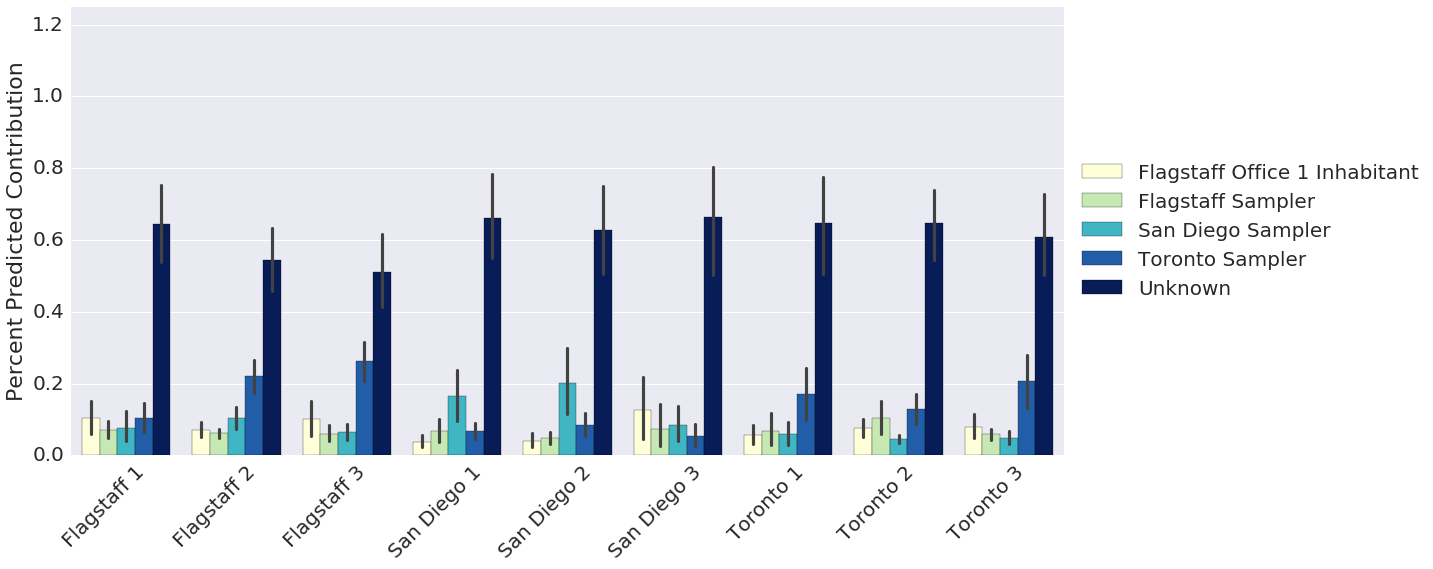

In [17]:
import matplotlib as mpl

df2 = df.sort_values('CityOffice').reset_index().copy()

with plt.rc_context(dict(sns.axes_style("darkgrid"),
                         **sns.plotting_context("notebook", font_scale=2))):
    
    plt.figure(figsize=(15,8))
    g = sns.barplot(x='CityOffice', y='value', hue='variable', 
                    saturation=1, data=df, order=['flagstaff 1','flagstaff 2', 'flagstaff 3',
                                                  'sandiego 1','sandiego 2', 'sandiego 3',
                                                  'toronto 1','toronto 2', 'toronto 3'],  
                    palette=mpl.cm.YlGnBu(np.linspace(0, 1, 5)))

    g.set_ylim(0, 1.25)
    g.set_ylabel('Percent Predicted Contribution')
    g.set_xlabel('')
    offices = ['Flagstaff 1','Flagstaff 2', 'Flagstaff 3',
               'San Diego 1','San Diego 2', 'San Diego 3',
               'Toronto 1','Toronto 2', 'Toronto 3',
             ]    
    plt.xticks(np.array([0, 1, 2, 3, 4, 5, 6, 7, 8])-.2, offices, rotation=45)
    handles, labels = g.get_legend_handles_labels()
    labels = ['Flagstaff Office 1 Inhabitant', 'Flagstaff Sampler', 'San Diego Sampler', 'Toronto Sampler', 'Unknown']
    plt.legend(handles, labels, loc='center left', bbox_to_anchor=(1, 0.5))
    plt.tight_layout()
    plt.savefig('figure-7-inhabitant.svg', dpi=300)

#Body site predictions

In [18]:
map_fp = '/home/johnchase/swabber_and_inhabitant/body_site_out/mixing_proportions.txt'
all_samples = pd.read_csv(map_fp, sep='\t', index_col=0)
all_samples.dropna(inplace=True)
all_samples['CityOffice'] = sample_md.loc[all_samples.index, 'City'] + ' ' + sample_md.loc[all_samples.index, 'OfficeNumber']

In [19]:
df = pd.melt(all_samples, id_vars=['CityOffice'])

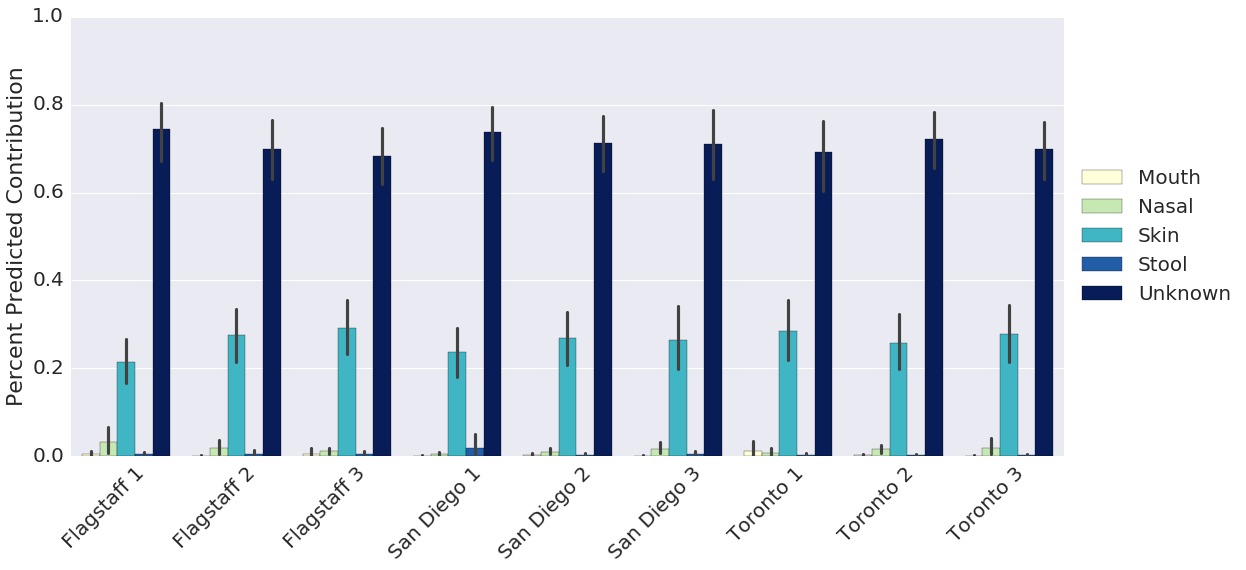

In [22]:
import matplotlib as mpl

df2 = df.sort_values('CityOffice').reset_index().copy()

with plt.rc_context(dict(sns.axes_style("darkgrid"),
                         **sns.plotting_context("notebook", font_scale=2))):
    
    plt.figure(figsize=(15,8))
    g = sns.barplot(x='CityOffice', y='value', hue='variable', 
                    saturation=1, data=df, order=['flagstaff 1','flagstaff 2', 'flagstaff 3',
                                                  'sandiego 1','sandiego 2', 'sandiego 3',
                                                  'toronto 1','toronto 2', 'toronto 3'],  
                    palette=mpl.cm.YlGnBu(np.linspace(0, 1, 5)))

    g.set_ylim(0, 1)
    g.set_ylabel('Percent Predicted Contribution')
    g.set_xlabel('')
    offices = ['Flagstaff 1','Flagstaff 2', 'Flagstaff 3',
               'San Diego 1','San Diego 2', 'San Diego 3',
               'Toronto 1','Toronto 2', 'Toronto 3',
             ]    
    plt.xticks(np.array([0, 1, 2, 3, 4, 5, 6, 7, 8])-.2, offices, rotation=45)
    handles, labels = g.get_legend_handles_labels()
    labels = ['Flagstaff Sampler', 'San Diego Sampler', 'Toronto Sampler', 'Unknown']
    plt.legend(handles, labels)
    plt.tight_layout()
    g.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.tight_layout()
    plt.savefig('figure-7-body-site.svg', dpi=300)